In [1]:
import sys, time, pickle
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
from pyspark.sql.types import *
from IPython.core.display import display, HTML
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pymongo import MongoClient
import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt

# make matplotlib plot sizes larger
plt.rcParams['figure.figsize'] = [30, 20]

conf = SparkConf().setAppName('Steam Random Forest Regressor').setMaster('spark://sparkmaster:7077')
SparkContext.setSystemProperty('spark.executor.memory', '2g') # memory per executor
SparkContext.setSystemProperty('spark.executor.cores', '6') # cores per executor
SparkContext.setSystemProperty('spark.executor.instances', '3') # per worker (computer)

# https://spark.apache.org/docs/3.0.0-preview/configuration.html#dynamic-allocation
# https://stackoverflow.com/questions/26168254/how-to-set-amount-of-spark-executors
# https://blog.cloudera.com/how-to-tune-your-apache-spark-jobs-part-2/

# SparkContext.setSystemProperty("spark.shuffle.service.enabled", "True") # required for dynamic allocation below
# SparkContext.setSystemProperty("spark.dynamicAllocation.enabled", "True")
# SparkContext.setSystemProperty("spark.executor.cores", "4")
# SparkContext.setSystemProperty("spark.dynamicAllocation.minExecutors", "1")
# SparkContext.setSystemProperty("spark.dynamicAllocation.maxExecutors", "5")
# SparkContext.setSystemProperty('spark.executor.memory', '2g') # memory per executor

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [2]:
# Customizable Variables

# what percentage discount should be predicted?
percentage_discount_predict = 25

In [3]:
sc._conf.getAll()

[('spark.executor.memory', '2g'),
 ('spark.driver.host', 'jupyterlab'),
 ('spark.executor.instances', '3'),
 ('spark.app.startTime', '1627009363802'),
 ('spark.app.name', 'Steam Random Forest Regressor'),
 ('spark.driver.port', '39481'),
 ('spark.executor.id', 'driver'),
 ('spark.master', 'spark://sparkmaster:7077'),
 ('spark.executor.cores', '6'),
 ('spark.app.id', 'app-20210722210244-0000'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
client = MongoClient(host="192.168.1.171", port=27017)
db = client['steam']
apps = db['apps']
history = db['pricehistory']
opencritic = db['opencritic']
topgames = db['topgames']
twitch = db['twitchhistorical']

# TODO: account for cases where there are multiple publishers or developers?
ret = apps.aggregate([
    {"$match": {"updated_date": {"$exists": True}, "type": {"$in": ["game", "dlc"]}, "release_date.coming_soon": {"$ne": True}, "is_free": False}},
    {"$project": {"_id":0, "name":1, "appid":1, "release_date": "$release_date.date", "total_recommendations": "$recommendations.total",
                  "initial_price": "$price_overview.initial", "metacritic_score": "$metacritic.score", "type":1, "required_age":1,
                 "windows":"$platforms.windows", "mac":"$platforms.mac", "linux":"$platforms.linux",
                 "publisher": {"$arrayElemAt": ["$publishers", 0]}, "developer": {"$arrayElemAt": ["$developers", 0]},
                 "number_dlc": {'$size': {"$ifNull": [ "$dlc", [] ]}}, "number_genres": {'$size': {"$ifNull": [ "$genres", [] ]}}, "number_categories": {'$size': {"$ifNull": [ "$categories", [] ]}}}}
])

In [5]:
# save as pandas dataframe
df = pd.DataFrame(ret)

In [6]:
df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,publisher,developer,number_dlc,number_genres,number_categories,total_recommendations
0,game,Legend: Hand of God,0,12630,"May 5, 2009",999.0,57.0,True,False,False,DTP Entertainment,Master Creating,0,2,1,NaN
1,game,realMyst,0,63600,"Aug 4, 2010",599.0,66.0,True,False,False,Cyan Worlds,Cyan Worlds,0,2,1,231.0
2,dlc,Crusader Kings II: African Portraits,0,210897,"Oct 16, 2012",199.0,NaN,True,True,True,Paradox Interactive,Paradox Interactive,0,1,3,NaN
3,game,Planetary Annihilation,0,233250,"Sep 5, 2014",2999.0,62.0,True,True,True,Planetary Annihilation Inc,Planetary Annihilation Inc,2,1,6,14931.0
4,dlc,Mark of the Ninja: Special Edition DLC,17,239570,"Aug 16, 2013",499.0,NaN,True,True,True,,Klei Entertainment,0,3,8,239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76361,dlc,Jurassic World Evolution: Claire's Sanctuary,0,1028430,2019-06-18 00:00:00,1499.0,NaN,True,False,False,Frontier Developments,Frontier Developments,0,2,6,329.0
76362,game,Alexio,0,1044480,2021-05-08 00:00:00,399.0,NaN,True,False,False,Duck team,Duck team,1,2,4,NaN
76363,dlc,Train Simulator: Guiguang High Speed Railway: ...,0,980547,2019-06-19 00:00:00,3999.0,NaN,True,False,False,Dovetail Games - Trains,Union Workshop,0,1,9,NaN
76364,dlc,TS Marketplace: Hudson Line Scenario Pack 01,0,980549,2019-06-19 00:00:00,999.0,NaN,True,False,False,Dovetail Games - Trains,High Iron Simulations,0,1,9,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76366 entries, 0 to 76365
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   76366 non-null  object 
 1   name                   76366 non-null  object 
 2   required_age           76366 non-null  object 
 3   appid                  76366 non-null  int64  
 4   release_date           76366 non-null  object 
 5   initial_price          71246 non-null  float64
 6   metacritic_score       3668 non-null   float64
 7   windows                76366 non-null  bool   
 8   mac                    76366 non-null  bool   
 9   linux                  76366 non-null  bool   
 10  publisher              76366 non-null  object 
 11  developer              75448 non-null  object 
 12  number_dlc             76366 non-null  int64  
 13  number_genres          76366 non-null  int64  
 14  number_categories      76366 non-null  int64  
 15  to

In [8]:
# fix cases where it lists '17+'
df['required_age'] = df['required_age'].replace(['17+'],'17')

# convert column to datetime
df['release_date'] = pd.to_datetime(df['release_date'])

# convert column to int64 type
df['required_age'] = pd.to_numeric(df['required_age'])

In [9]:
# figure out the release day in the year
df['release_day_in_year'] = df['release_date'].dt.dayofyear

In [10]:
# aggregate the steam recommendations and tie them in

ret = apps.aggregate([
    {"$unwind":"$reviews"},
    {"$unwind":"$reviews.rollups"},
    {
        "$group": {
            "_id": "$appid",
           "sum_recommendations_up": {"$sum": "$reviews.rollups.recommendations_up"},
            "sum_recommendations_down": {"$sum": "$reviews.rollups.recommendations_down"}
        }
    }
])

# save as pandas dataframe
recommendations = pd.DataFrame(ret)
recommendations = recommendations.rename(columns={"_id": "appid"})

recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55081 entries, 0 to 55080
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   appid                     55081 non-null  int64
 1   sum_recommendations_up    55081 non-null  int64
 2   sum_recommendations_down  55081 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [11]:
df = pd.merge(df, recommendations, on="appid", how="left")
del recommendations

In [12]:
df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,publisher,developer,number_dlc,number_genres,number_categories,total_recommendations,release_day_in_year,sum_recommendations_up,sum_recommendations_down
0,game,Legend: Hand of God,0,12630,2009-05-05,999.0,57.0,True,False,False,DTP Entertainment,Master Creating,0,2,1,NaN,125.0,15.0,10.0
1,game,realMyst,0,63600,2010-08-04,599.0,66.0,True,False,False,Cyan Worlds,Cyan Worlds,0,2,1,231.0,216.0,132.0,87.0
2,dlc,Crusader Kings II: African Portraits,0,210897,2012-10-16,199.0,NaN,True,True,True,Paradox Interactive,Paradox Interactive,0,1,3,NaN,290.0,19.0,7.0
3,game,Planetary Annihilation,0,233250,2014-09-05,2999.0,62.0,True,True,True,Planetary Annihilation Inc,Planetary Annihilation Inc,2,1,6,14931.0,248.0,6268.0,4576.0
4,dlc,Mark of the Ninja: Special Edition DLC,17,239570,2013-08-16,499.0,NaN,True,True,True,,Klei Entertainment,0,3,8,239.0,228.0,195.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76361,dlc,Jurassic World Evolution: Claire's Sanctuary,0,1028430,2019-06-18,1499.0,NaN,True,False,False,Frontier Developments,Frontier Developments,0,2,6,329.0,169.0,NaN,NaN
76362,game,Alexio,0,1044480,2021-05-08,399.0,NaN,True,False,False,Duck team,Duck team,1,2,4,NaN,128.0,NaN,NaN
76363,dlc,Train Simulator: Guiguang High Speed Railway: ...,0,980547,2019-06-19,3999.0,NaN,True,False,False,Dovetail Games - Trains,Union Workshop,0,1,9,NaN,170.0,NaN,NaN
76364,dlc,TS Marketplace: Hudson Line Scenario Pack 01,0,980549,2019-06-19,999.0,NaN,True,False,False,Dovetail Games - Trains,High Iron Simulations,0,1,9,NaN,170.0,NaN,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76366 entries, 0 to 76365
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   type                      76366 non-null  object        
 1   name                      76366 non-null  object        
 2   required_age              76366 non-null  int64         
 3   appid                     76366 non-null  int64         
 4   release_date              76066 non-null  datetime64[ns]
 5   initial_price             71246 non-null  float64       
 6   metacritic_score          3668 non-null   float64       
 7   windows                   76366 non-null  bool          
 8   mac                       76366 non-null  bool          
 9   linux                     76366 non-null  bool          
 10  publisher                 76366 non-null  object        
 11  developer                 75448 non-null  object        
 12  number_dlc        

In [14]:
ret = history.aggregate([
    {"$match": {"discount_percent": {"$gte": percentage_discount_predict}}},
    {"$group": {"_id": "$appid", "date": {"$min": "$date"}}},
    {"$project": {"_id":0, "appid":"$_id", "date":1}}
])

In [15]:
history_df = pd.DataFrame(ret)

In [16]:
history_df

,date,appid
0,2018-11-22 00:41:30.596,735280
1,2018-11-01 00:06:19.477,860670
2,2018-11-01 00:11:40.225,918460
3,2018-11-01 00:22:43.157,431030
4,2020-04-02 18:52:49.644,904900
...,...,...
59798,2018-11-01 00:21:27.837,855270
59799,2021-06-26 16:23:29.649,1271750
59800,2021-03-17 09:21:45.023,1509400
59801,2018-10-03 01:53:51.924,206145


In [17]:
history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59803 entries, 0 to 59802
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    59803 non-null  datetime64[ns]
 1   appid   59803 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 934.5 KB


In [18]:
df = pd.merge(df, history_df, on="appid", how="left")
del history_df

In [19]:
# find time in days between release and at least X% off
df['days_until_discount'] = df['date'] - df['release_date']
df['days_until_discount'] = df['days_until_discount'] / np.timedelta64(1,"D")

In [20]:
df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,...,developer,number_dlc,number_genres,number_categories,total_recommendations,release_day_in_year,sum_recommendations_up,sum_recommendations_down,date,days_until_discount
0,game,Legend: Hand of God,0,12630,2009-05-05,999.0,57.0,True,False,False,...,Master Creating,0,2,1,NaN,125.0,15.0,10.0,NaT,NaN
1,game,realMyst,0,63600,2010-08-04,599.0,66.0,True,False,False,...,Cyan Worlds,0,2,1,231.0,216.0,132.0,87.0,NaT,NaN
2,dlc,Crusader Kings II: African Portraits,0,210897,2012-10-16,199.0,NaN,True,True,True,...,Paradox Interactive,0,1,3,NaN,290.0,19.0,7.0,2018-09-07 02:06:54.097,2152.088126
3,game,Planetary Annihilation,0,233250,2014-09-05,2999.0,62.0,True,True,True,...,Planetary Annihilation Inc,2,1,6,14931.0,248.0,6268.0,4576.0,NaT,NaN
4,dlc,Mark of the Ninja: Special Edition DLC,17,239570,2013-08-16,499.0,NaN,True,True,True,...,Klei Entertainment,0,3,8,239.0,228.0,195.0,19.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76361,dlc,Jurassic World Evolution: Claire's Sanctuary,0,1028430,2019-06-18,1499.0,NaN,True,False,False,...,Frontier Developments,0,2,6,329.0,169.0,NaN,NaN,2019-11-29 20:50:50.196,164.868637
76362,game,Alexio,0,1044480,2021-05-08,399.0,NaN,True,False,False,...,Duck team,1,2,4,NaN,128.0,NaN,NaN,NaT,NaN
76363,dlc,Train Simulator: Guiguang High Speed Railway: ...,0,980547,2019-06-19,3999.0,NaN,True,False,False,...,Union Workshop,0,1,9,NaN,170.0,NaN,NaN,2019-11-29 20:50:50.197,163.868637
76364,dlc,TS Marketplace: Hudson Line Scenario Pack 01,0,980549,2019-06-19,999.0,NaN,True,False,False,...,High Iron Simulations,0,1,9,NaN,170.0,NaN,NaN,2019-12-21 02:14:51.934,185.093657


In [21]:
# get top games information

ret = topgames.aggregate([
    {"$match": {}},
    {"$project": {"_id":0, "date":1, "appid":1, "currentplayers":1, "peaktoday":1}}
])
tgames = pd.DataFrame(ret)
tgames['appid'] = pd.to_numeric(tgames['appid'])

tgames = pd.merge(tgames, df[["appid", "release_date"]], on="appid", how="left").dropna()

tgames

,date,appid,currentplayers,peaktoday,release_date
0,2019-01-08 04:04:02.491,578080,301313,970440,2017-12-21
3,2019-01-08 04:04:02.491,359550,63224,101320,2015-12-01
6,2019-01-08 04:04:02.491,271590,42480,90011,2015-04-13
7,2019-01-08 04:04:02.491,252490,39405,66405,2018-02-08
8,2019-01-08 04:04:02.491,582010,38731,74605,2018-08-09
...,...,...,...,...,...
7336364,2021-07-23 03:05:07.817,22380,6421,6849,2010-10-19
7336366,2021-07-23 03:05:07.817,1328670,6354,7294,2021-05-14
7336368,2021-07-23 03:05:07.817,1238810,6206,14775,2020-10-22
7336370,2021-07-23 03:05:07.817,242760,5979,9125,2018-04-30


In [22]:
tgames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568182 entries, 0 to 7336371
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   appid           int64         
 2   currentplayers  int64         
 3   peaktoday       int64         
 4   release_date    datetime64[ns]
dtypes: datetime64[ns](2), int64(3)
memory usage: 254.9 MB


In [23]:
# find difference between entry date and release date
tgames['days_since_release'] = (tgames['date'] - tgames['release_date']).dt.days

#tgames.query("appid==1097150 & days_since_release>=0 & days_since_release<=30")
tgames

,date,appid,currentplayers,peaktoday,release_date,days_since_release
0,2019-01-08 04:04:02.491,578080,301313,970440,2017-12-21,383
3,2019-01-08 04:04:02.491,359550,63224,101320,2015-12-01,1134
6,2019-01-08 04:04:02.491,271590,42480,90011,2015-04-13,1366
7,2019-01-08 04:04:02.491,252490,39405,66405,2018-02-08,334
8,2019-01-08 04:04:02.491,582010,38731,74605,2018-08-09,152
...,...,...,...,...,...,...
7336364,2021-07-23 03:05:07.817,22380,6421,6849,2010-10-19,3930
7336366,2021-07-23 03:05:07.817,1328670,6354,7294,2021-05-14,70
7336368,2021-07-23 03:05:07.817,1238810,6206,14775,2020-10-22,274
7336370,2021-07-23 03:05:07.817,242760,5979,9125,2018-04-30,1180


In [24]:
bins = range(-1, 7, 1)
groups = tgames.groupby(['appid', pd.cut(tgames.days_since_release, bins, labels=["start_players_{:01d}".format(x) for x in bins[:-1]])])
groups = groups.mean().currentplayers.unstack()
groups = groups.fillna(0)

#groups[groups.index.isin([1097150])]
groups

days_since_release,start_players_-1,start_players_0,start_players_1,start_players_2,start_players_3,start_players_4,start_players_5
appid,,,,,,,
10,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
70,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
220,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
240,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
550,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1526490,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
1530870,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
1541780,0.0,0.000000,0.000000,11470.125,0.0,0.0,0.0


In [25]:
df = pd.merge(df, groups, left_on="appid", right_index=True, how="left")
del groups
del tgames

df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,...,sum_recommendations_down,date,days_until_discount,start_players_-1,start_players_0,start_players_1,start_players_2,start_players_3,start_players_4,start_players_5
0,game,Legend: Hand of God,0,12630,2009-05-05,999.0,57.0,True,False,False,...,10.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,game,realMyst,0,63600,2010-08-04,599.0,66.0,True,False,False,...,87.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dlc,Crusader Kings II: African Portraits,0,210897,2012-10-16,199.0,NaN,True,True,True,...,7.0,2018-09-07 02:06:54.097,2152.088126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,game,Planetary Annihilation,0,233250,2014-09-05,2999.0,62.0,True,True,True,...,4576.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dlc,Mark of the Ninja: Special Edition DLC,17,239570,2013-08-16,499.0,NaN,True,True,True,...,19.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76361,dlc,Jurassic World Evolution: Claire's Sanctuary,0,1028430,2019-06-18,1499.0,NaN,True,False,False,...,NaN,2019-11-29 20:50:50.196,164.868637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76362,game,Alexio,0,1044480,2021-05-08,399.0,NaN,True,False,False,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76363,dlc,Train Simulator: Guiguang High Speed Railway: ...,0,980547,2019-06-19,3999.0,NaN,True,False,False,...,NaN,2019-11-29 20:50:50.197,163.868637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76364,dlc,TS Marketplace: Hudson Line Scenario Pack 01,0,980549,2019-06-19,999.0,NaN,True,False,False,...,NaN,2019-12-21 02:14:51.934,185.093657,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76366 entries, 0 to 76365
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   type                      76366 non-null  object        
 1   name                      76366 non-null  object        
 2   required_age              76366 non-null  int64         
 3   appid                     76366 non-null  int64         
 4   release_date              76066 non-null  datetime64[ns]
 5   initial_price             71246 non-null  float64       
 6   metacritic_score          3668 non-null   float64       
 7   windows                   76366 non-null  bool          
 8   mac                       76366 non-null  bool          
 9   linux                     76366 non-null  bool          
 10  publisher                 76366 non-null  object        
 11  developer                 75448 non-null  object        
 12  number_dlc        

In [27]:
# get twitch games

ret = twitch.aggregate([
    {"$match": {}},
    {"$project": {"_id":0, "date":1, "name":1, "gamerank":1, "viewer_count":1}}
])
twitch_df = pd.DataFrame(ret)

twitch_df = pd.merge(twitch_df, df[["name", "release_date"]], on="name", how="left").dropna()

twitch_df

,viewer_count,date,name,gamerank,release_date
300,9084,2019-07-14 19:01:26.131,Grand Theft Auto V,4,2015-04-13
301,8128,2019-07-14 19:01:26.144,Grand Theft Auto V,4,2015-04-13
302,7858,2019-07-14 19:01:26.157,Grand Theft Auto V,4,2015-04-13
303,5847,2019-07-14 19:01:26.170,Grand Theft Auto V,4,2015-04-13
304,4803,2019-07-14 19:01:26.183,Grand Theft Auto V,4,2015-04-13
...,...,...,...,...,...
13807800,7,2021-07-22 22:10:50.859,Phasmophobia,96,2020-09-18
13807801,7,2021-07-22 22:10:50.861,Phasmophobia,96,2020-09-18
13807802,7,2021-07-22 22:10:50.863,Phasmophobia,96,2020-09-18
13807803,7,2021-07-22 22:10:50.866,Phasmophobia,96,2020-09-18


In [28]:
twitch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4055292 entries, 300 to 13807804
Data columns (total 5 columns):
 #   Column        Dtype         
---  ------        -----         
 0   viewer_count  int64         
 1   date          datetime64[ns]
 2   name          object        
 3   gamerank      int64         
 4   release_date  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 185.6+ MB


In [29]:
# find difference between entry date and release date
twitch_df['days_since_release'] = (twitch_df['date'] - twitch_df['release_date']).dt.days

#twitch_df.query("appid==1097150 & days_since_release>=0 & days_since_release<=30")
twitch_df

,viewer_count,date,name,gamerank,release_date,days_since_release
300,9084,2019-07-14 19:01:26.131,Grand Theft Auto V,4,2015-04-13,1553
301,8128,2019-07-14 19:01:26.144,Grand Theft Auto V,4,2015-04-13,1553
302,7858,2019-07-14 19:01:26.157,Grand Theft Auto V,4,2015-04-13,1553
303,5847,2019-07-14 19:01:26.170,Grand Theft Auto V,4,2015-04-13,1553
304,4803,2019-07-14 19:01:26.183,Grand Theft Auto V,4,2015-04-13,1553
...,...,...,...,...,...,...
13807800,7,2021-07-22 22:10:50.859,Phasmophobia,96,2020-09-18,307
13807801,7,2021-07-22 22:10:50.861,Phasmophobia,96,2020-09-18,307
13807802,7,2021-07-22 22:10:50.863,Phasmophobia,96,2020-09-18,307
13807803,7,2021-07-22 22:10:50.866,Phasmophobia,96,2020-09-18,307


In [30]:
bins = range(-1, 7, 1)
groups_viewers = twitch_df.groupby(['name', pd.cut(twitch_df.days_since_release, bins, labels=["start_twitch_viewers_{:01d}".format(x) for x in bins[:-1]])])
groups_viewers = groups_viewers.mean().viewer_count.unstack()
groups_viewers = groups_viewers.fillna(0)

groups_viewers

days_since_release,start_twitch_viewers_-1,start_twitch_viewers_0,start_twitch_viewers_1,start_twitch_viewers_2,start_twitch_viewers_3,start_twitch_viewers_4,start_twitch_viewers_5
name,,,,,,,
.hack//G.U. Last Recode,0.0,0.0,0.00,0.0,0.0,0.0,0.0
112 Operator,0.0,1721.0,0.00,0.0,0.0,0.0,0.0
12 Labours of Hercules II: The Cretan Bull,0.0,0.0,0.00,0.0,0.0,0.0,0.0
140,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1406,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
ibb & obb,0.0,0.0,0.00,0.0,0.0,0.0,0.0
looK INside,0.0,0.0,0.00,0.0,0.0,0.0,0.0
ppL: The Animated Adventures,451.0,0.0,1819.50,0.0,0.0,0.0,0.0


In [31]:
bins = range(-1, 7, 1)
groups_rank = twitch_df.groupby(['name', pd.cut(twitch_df.days_since_release, bins, labels=["start_twitch_rank_{:01d}".format(x) for x in bins[:-1]])])
groups_rank = groups_rank.mean().gamerank.unstack()
groups_rank = groups_rank.fillna(0)

groups_rank

days_since_release,start_twitch_rank_-1,start_twitch_rank_0,start_twitch_rank_1,start_twitch_rank_2,start_twitch_rank_3,start_twitch_rank_4,start_twitch_rank_5
name,,,,,,,
.hack//G.U. Last Recode,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112 Operator,0.0,23.0,0.0,0.0,0.0,0.0,0.0
12 Labours of Hercules II: The Cretan Bull,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1406,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
ibb & obb,0.0,0.0,0.0,0.0,0.0,0.0,0.0
looK INside,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ppL: The Animated Adventures,94.0,0.0,88.0,0.0,0.0,0.0,0.0


In [32]:
# merge twitch viewership and gamerank back into master df
df = pd.merge(df, groups_viewers, left_on="name", right_index=True, how="left")
del groups_viewers
df = pd.merge(df, groups_rank, left_on="name", right_index=True, how="left")
del groups_rank

del twitch_df

In [33]:
# fill in all the NaN spots
players_filter_col = [c for c in df.columns if c.startswith('start')]
print(players_filter_col)
df[players_filter_col] = df[players_filter_col].fillna(0)

['start_players_-1', 'start_players_0', 'start_players_1', 'start_players_2', 'start_players_3', 'start_players_4', 'start_players_5', 'start_twitch_viewers_-1', 'start_twitch_viewers_0', 'start_twitch_viewers_1', 'start_twitch_viewers_2', 'start_twitch_viewers_3', 'start_twitch_viewers_4', 'start_twitch_viewers_5', 'start_twitch_rank_-1', 'start_twitch_rank_0', 'start_twitch_rank_1', 'start_twitch_rank_2', 'start_twitch_rank_3', 'start_twitch_rank_4', 'start_twitch_rank_5']


In [34]:
df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,...,start_twitch_viewers_3,start_twitch_viewers_4,start_twitch_viewers_5,start_twitch_rank_-1,start_twitch_rank_0,start_twitch_rank_1,start_twitch_rank_2,start_twitch_rank_3,start_twitch_rank_4,start_twitch_rank_5
0,game,Legend: Hand of God,0,12630,2009-05-05,999.0,57.0,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,game,realMyst,0,63600,2010-08-04,599.0,66.0,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dlc,Crusader Kings II: African Portraits,0,210897,2012-10-16,199.0,NaN,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,game,Planetary Annihilation,0,233250,2014-09-05,2999.0,62.0,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dlc,Mark of the Ninja: Special Edition DLC,17,239570,2013-08-16,499.0,NaN,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76361,dlc,Jurassic World Evolution: Claire's Sanctuary,0,1028430,2019-06-18,1499.0,NaN,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76362,game,Alexio,0,1044480,2021-05-08,399.0,NaN,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76363,dlc,Train Simulator: Guiguang High Speed Railway: ...,0,980547,2019-06-19,3999.0,NaN,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76364,dlc,TS Marketplace: Hudson Line Scenario Pack 01,0,980549,2019-06-19,999.0,NaN,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76366 entries, 0 to 76365
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   type                      76366 non-null  object        
 1   name                      76366 non-null  object        
 2   required_age              76366 non-null  int64         
 3   appid                     76366 non-null  int64         
 4   release_date              76066 non-null  datetime64[ns]
 5   initial_price             71246 non-null  float64       
 6   metacritic_score          3668 non-null   float64       
 7   windows                   76366 non-null  bool          
 8   mac                       76366 non-null  bool          
 9   linux                     76366 non-null  bool          
 10  publisher                 76366 non-null  object        
 11  developer                 75448 non-null  object        
 12  number_dlc        

In [36]:
ret = opencritic.aggregate([
    {"$match": {"steamId": {"$exists": True, "$nin": [None, "", "null", "NaN"], "$not": {"$type": 10}}}},
    {"$project": {"_id":0, "appid":"$steamId", "game_type":"$type", "hasLootBoxes":1, "isMajorTitle":1, "medianScore":1, "numReviews":1,
                  "numTopCriticReviews":1, "percentRecommended":1, "percentile":1, "tier":1, "topCriticScore":1,
                 "number_platforms": {'$size': {"$ifNull": [ "$Platforms", [] ]}}, "number_skus": {'$size': {"$ifNull": [ "$Skus", [] ]}}}}
])

In [37]:
opencritic_df = pd.DataFrame(ret)

# fix cases where we don't have data
opencritic_df = opencritic_df.replace({'medianScore': -1, 'percentRecommended': -1, 'percentile': -1, 'topCriticScore': -1}, np.nan)

opencritic_df

,hasLootBoxes,isMajorTitle,medianScore,numReviews,numTopCriticReviews,percentRecommended,percentile,tier,topCriticScore,appid,game_type,number_platforms,number_skus
0,None,False,NaN,1,1,NaN,NaN,,NaN,1000380,BASE,1,1
1,None,False,NaN,2,2,NaN,NaN,,NaN,1000640,BASE,1,1
2,None,False,78.0,42,28,54.761905,66.0,Strong,76.500000,1001060,BASE,7,7
3,None,False,75.0,11,9,45.454545,63.0,Strong,75.444444,1001140,BASE,1,1
4,None,False,NaN,1,1,NaN,NaN,,NaN,1001570,BASE,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4786,False,False,NaN,1,1,NaN,NaN,,NaN,995860,BASE,1,6
4787,None,True,82.0,71,48,80.597015,83.0,Strong,81.270833,996470,BASE,5,18
4788,None,False,60.0,11,6,45.454545,21.0,Weak,62.500000,997060,BASE,4,4
4789,None,False,NaN,4,3,NaN,83.0,Strong,81.666667,998990,BASE,2,1


In [38]:
opencritic_df.describe()

,medianScore,numReviews,numTopCriticReviews,percentRecommended,percentile,topCriticScore,number_platforms,number_skus
count,2801.000000,4791.000000,4791.000000,2831.000000,3000.000000,3000.000000,4791.000000,4791.000000
mean,71.329382,17.390106,12.635984,45.839691,47.860000,69.616268,2.584847,3.513463
std,11.352791,26.178717,19.105985,27.829782,27.438635,11.269988,1.869392,3.114612
min,20.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000
25%,65.000000,2.000000,1.000000,22.222222,24.000000,63.500000,1.000000,1.000000
50%,71.000000,7.000000,5.000000,44.210526,48.000000,71.245690,2.000000,3.000000
75%,80.000000,21.000000,15.000000,68.571429,70.000000,77.658602,5.000000,5.000000
max,98.000000,202.000000,132.000000,100.000000,100.000000,95.873239,8.000000,46.000000


In [39]:
# convert object to int64 type
opencritic_df["appid"] = pd.to_numeric(opencritic_df["appid"])

In [40]:
# NaNs will be pruned out later, in order to use as much of the sparse OpenCritic data that we have, we fill it in with zeros
opencritic_df.fillna(0, inplace=True)

In [41]:
opencritic_df

,hasLootBoxes,isMajorTitle,medianScore,numReviews,numTopCriticReviews,percentRecommended,percentile,tier,topCriticScore,appid,game_type,number_platforms,number_skus
0,0,False,0.0,1,1,0.000000,0.0,,0.000000,1000380,BASE,1,1
1,0,False,0.0,2,2,0.000000,0.0,,0.000000,1000640,BASE,1,1
2,0,False,78.0,42,28,54.761905,66.0,Strong,76.500000,1001060,BASE,7,7
3,0,False,75.0,11,9,45.454545,63.0,Strong,75.444444,1001140,BASE,1,1
4,0,False,0.0,1,1,0.000000,0.0,,0.000000,1001570,BASE,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4786,False,False,0.0,1,1,0.000000,0.0,,0.000000,995860,BASE,1,6
4787,0,True,82.0,71,48,80.597015,83.0,Strong,81.270833,996470,BASE,5,18
4788,0,False,60.0,11,6,45.454545,21.0,Weak,62.500000,997060,BASE,4,4
4789,0,False,0.0,4,3,0.000000,83.0,Strong,81.666667,998990,BASE,2,1


In [42]:
opencritic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hasLootBoxes         4791 non-null   object 
 1   isMajorTitle         4791 non-null   bool   
 2   medianScore          4791 non-null   float64
 3   numReviews           4791 non-null   int64  
 4   numTopCriticReviews  4791 non-null   int64  
 5   percentRecommended   4791 non-null   float64
 6   percentile           4791 non-null   float64
 7   tier                 4791 non-null   object 
 8   topCriticScore       4791 non-null   float64
 9   appid                4791 non-null   int64  
 10  game_type            4791 non-null   object 
 11  number_platforms     4791 non-null   int64  
 12  number_skus          4791 non-null   int64  
dtypes: bool(1), float64(4), int64(5), object(3)
memory usage: 454.0+ KB


In [43]:
df = pd.merge(df, opencritic_df, on="appid", how="left")
del opencritic_df

In [44]:
df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,...,medianScore,numReviews,numTopCriticReviews,percentRecommended,percentile,tier,topCriticScore,game_type,number_platforms,number_skus
0,game,Legend: Hand of God,0,12630,2009-05-05,999.0,57.0,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,game,realMyst,0,63600,2010-08-04,599.0,66.0,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dlc,Crusader Kings II: African Portraits,0,210897,2012-10-16,199.0,NaN,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,game,Planetary Annihilation,0,233250,2014-09-05,2999.0,62.0,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dlc,Mark of the Ninja: Special Edition DLC,17,239570,2013-08-16,499.0,NaN,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76447,dlc,Jurassic World Evolution: Claire's Sanctuary,0,1028430,2019-06-18,1499.0,NaN,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76448,game,Alexio,0,1044480,2021-05-08,399.0,NaN,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76449,dlc,Train Simulator: Guiguang High Speed Railway: ...,0,980547,2019-06-19,3999.0,NaN,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76450,dlc,TS Marketplace: Hudson Line Scenario Pack 01,0,980549,2019-06-19,999.0,NaN,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/
# TODO: use mean or median for cases where we have missing data



# just assume anything not filled in doesn't have loot boxes
#df = df.replace({'hasLootBoxes': np.nan}, False)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76452 entries, 0 to 76451
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   type                      76452 non-null  object        
 1   name                      76452 non-null  object        
 2   required_age              76452 non-null  int64         
 3   appid                     76452 non-null  int64         
 4   release_date              76152 non-null  datetime64[ns]
 5   initial_price             71328 non-null  float64       
 6   metacritic_score          3709 non-null   float64       
 7   windows                   76452 non-null  bool          
 8   mac                       76452 non-null  bool          
 9   linux                     76452 non-null  bool          
 10  publisher                 76452 non-null  object        
 11  developer                 75534 non-null  object        
 12  number_dlc        

In [47]:
# we can't run prediction with empty values
# make a copy so we can continue modifying the dataframe
df = df.dropna().copy()

In [48]:
df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,...,medianScore,numReviews,numTopCriticReviews,percentRecommended,percentile,tier,topCriticScore,game_type,number_platforms,number_skus
329,game,OVERKILL's The Walking Dead,17,717690,2018-11-06,2999.0,51.0,True,False,False,...,55.0,39.0,28.0,10.526316,9.0,Weak,53.178571,BASE,5.0,10.0
3562,game,Hyper Light Drifter,0,257850,2016-03-31,1999.0,84.0,True,True,True,...,85.0,60.0,42.0,85.964912,90.0,Mighty,83.738095,BASE,6.0,7.0
3658,game,Marooners,0,423810,2016-09-15,999.0,70.0,True,True,True,...,70.0,14.0,9.0,35.714286,16.0,Weak,59.444444,BASE,5.0,4.0
3776,game,The Witcher 3: Wild Hunt,0,292030,2015-05-18,3999.0,93.0,True,False,False,...,92.0,125.0,104.0,95.121951,99.0,Mighty,91.759615,BASE,5.0,10.0
3789,game,Stick It To The Man!,0,251830,2013-12-13,799.0,83.0,True,True,False,...,80.0,39.0,23.0,82.857143,76.0,Strong,79.565217,BASE,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76181,game,"Invisible, Inc.",0,243970,2015-05-12,1999.0,82.0,True,True,True,...,85.0,43.0,37.0,82.926829,90.0,Strong,83.243243,BASE,4.0,3.0
76182,game,Take On Mars,0,244030,2017-02-09,2699.0,62.0,True,False,False,...,0.0,2.0,1.0,0.000000,0.0,,0.000000,BASE,1.0,1.0
76192,game,Party Hard 2,0,572430,2018-10-25,1999.0,74.0,True,True,False,...,70.0,27.0,13.0,51.851852,41.0,Fair,69.923077,BASE,1.0,6.0
76215,game,My Friend Pedro,0,557340,2019-06-20,1999.0,81.0,True,False,False,...,80.0,108.0,63.0,81.132075,81.0,Strong,80.047619,BASE,2.0,6.0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354 entries, 329 to 76252
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   type                      1354 non-null   object        
 1   name                      1354 non-null   object        
 2   required_age              1354 non-null   int64         
 3   appid                     1354 non-null   int64         
 4   release_date              1354 non-null   datetime64[ns]
 5   initial_price             1354 non-null   float64       
 6   metacritic_score          1354 non-null   float64       
 7   windows                   1354 non-null   bool          
 8   mac                       1354 non-null   bool          
 9   linux                     1354 non-null   bool          
 10  publisher                 1354 non-null   object        
 11  developer                 1354 non-null   object        
 12  number_dlc       

In [50]:
feature_list = ['required_age', 'metacritic_score', 'sum_recommendations_up', 'sum_recommendations_down', 'total_recommendations', 'initial_price', 'windows_num',
                'mac_num', 'linux_num', 'developer_num', 'publisher_num',
               'number_dlc', 'release_day_in_year', 'number_genres', 'number_categories']

# items from OpenCritic
feature_list = feature_list + ['type_num', 'hasLootBoxes_num', 'isMajorTitle_num',
            'tier_num', 'game_type_num', 'medianScore', 'numReviews', 'numTopCriticReviews', 'percentRecommended', 'percentile',
            'topCriticScore', 'number_platforms', 'number_skus']

feature_list = feature_list + players_filter_col
print(feature_list)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

['required_age', 'metacritic_score', 'sum_recommendations_up', 'sum_recommendations_down', 'total_recommendations', 'initial_price', 'windows_num', 'mac_num', 'linux_num', 'developer_num', 'publisher_num', 'number_dlc', 'release_day_in_year', 'number_genres', 'number_categories', 'type_num', 'hasLootBoxes_num', 'isMajorTitle_num', 'tier_num', 'game_type_num', 'medianScore', 'numReviews', 'numTopCriticReviews', 'percentRecommended', 'percentile', 'topCriticScore', 'number_platforms', 'number_skus', 'start_players_-1', 'start_players_0', 'start_players_1', 'start_players_2', 'start_players_3', 'start_players_4', 'start_players_5', 'start_twitch_viewers_-1', 'start_twitch_viewers_0', 'start_twitch_viewers_1', 'start_twitch_viewers_2', 'start_twitch_viewers_3', 'start_twitch_viewers_4', 'start_twitch_viewers_5', 'start_twitch_rank_-1', 'start_twitch_rank_0', 'start_twitch_rank_1', 'start_twitch_rank_2', 'start_twitch_rank_3', 'start_twitch_rank_4', 'start_twitch_rank_5']


In [51]:
# https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml
# an example Random Forest in Spark

In [52]:
# encode columns to numeric so we can run regression(s)

# items from OpenCritic
df['type_num'] = pd.factorize(df['type'])[0]
df['hasLootBoxes_num'] = pd.factorize(df['hasLootBoxes'])[0]
df['isMajorTitle_num'] = pd.factorize(df['isMajorTitle'])[0]
df['tier_num'] = pd.factorize(df['tier'])[0]
df['game_type_num'] = pd.factorize(df['game_type'])[0]

df['windows_num'] = pd.factorize(df['windows'])[0]
df['mac_num'] = pd.factorize(df['mac'])[0]
df['linux_num'] = pd.factorize(df['linux'])[0]
df['developer_num'] = pd.factorize(df['developer'])[0]
df['publisher_num'] = pd.factorize(df['publisher'])[0]

In [53]:
df

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,...,type_num,hasLootBoxes_num,isMajorTitle_num,tier_num,game_type_num,windows_num,mac_num,linux_num,developer_num,publisher_num
329,game,OVERKILL's The Walking Dead,17,717690,2018-11-06,2999.0,51.0,True,False,False,...,0,0,0,0,0,0,0,0,0,0
3562,game,Hyper Light Drifter,0,257850,2016-03-31,1999.0,84.0,True,True,True,...,0,0,1,1,0,0,1,1,1,1
3658,game,Marooners,0,423810,2016-09-15,999.0,70.0,True,True,True,...,0,0,0,0,0,0,1,1,2,2
3776,game,The Witcher 3: Wild Hunt,0,292030,2015-05-18,3999.0,93.0,True,False,False,...,0,0,0,1,0,0,0,0,3,3
3789,game,Stick It To The Man!,0,251830,2013-12-13,799.0,83.0,True,True,False,...,0,0,0,2,0,0,1,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76181,game,"Invisible, Inc.",0,243970,2015-05-12,1999.0,82.0,True,True,True,...,0,0,1,2,0,0,1,1,303,209
76182,game,Take On Mars,0,244030,2017-02-09,2699.0,62.0,True,False,False,...,0,0,0,4,0,0,0,0,967,620
76192,game,Party Hard 2,0,572430,2018-10-25,1999.0,74.0,True,True,False,...,0,0,0,3,0,0,1,0,814,41
76215,game,My Friend Pedro,0,557340,2019-06-20,1999.0,81.0,True,False,False,...,0,0,1,2,0,0,0,0,968,6


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354 entries, 329 to 76252
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   type                      1354 non-null   object        
 1   name                      1354 non-null   object        
 2   required_age              1354 non-null   int64         
 3   appid                     1354 non-null   int64         
 4   release_date              1354 non-null   datetime64[ns]
 5   initial_price             1354 non-null   float64       
 6   metacritic_score          1354 non-null   float64       
 7   windows                   1354 non-null   bool          
 8   mac                       1354 non-null   bool          
 9   linux                     1354 non-null   bool          
 10  publisher                 1354 non-null   object        
 11  developer                 1354 non-null   object        
 12  number_dlc       

In [55]:
# TODO: qq plot, residuals, etc.
# https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Regression/Regression_Diagnostics.ipynb
# https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685


In [56]:
# perform k-means clustering to create an additional numeric column for feature engineering
# https://www.kaggle.com/ryanholbrook/clustering-with-k-means
# https://spark.apache.org/docs/latest/ml-clustering.html

# https://stackoverflow.com/questions/37513355/converting-pandas-dataframe-into-spark-dataframe-error
schema = StructType([ StructField("type", StringType(), True)\
                       ,StructField("name", StringType(), True)\
                       ,StructField("required_age", IntegerType(), True)\
                       ,StructField("appid", IntegerType(), True)\
                       ,StructField("release_date", DateType(), True)\
                       ,StructField("initial_price", DoubleType(), True)\
                       ,StructField("metacritic_score", DoubleType(), True)\
                       ,StructField("windows", BooleanType(), True)\
                       ,StructField("mac", BooleanType(), True)\
                       ,StructField("linux", BooleanType(), True)\
                       ,StructField("publisher", StringType(), True)\
                       ,StructField("developer", StringType(), True)\
                       ,StructField("number_dlc", IntegerType(), True)\
                       ,StructField("number_genres", IntegerType(), True)\
                       ,StructField("number_categories", IntegerType(), True)\
                       ,StructField("total_recommendations", DoubleType(), True)\
                       ,StructField("release_day_in_year", DoubleType(), True)\
                       ,StructField("sum_recommendations_up", DoubleType(), True)\
                       ,StructField("sum_recommendations_down", DoubleType(), True)\
                       ,StructField("date", DateType(), True)\
                       ,StructField("days_until_discount", DoubleType(), True)\
                       ,StructField("start_players_-1", DoubleType(), True)\
                       ,StructField("start_players_0", DoubleType(), True)\
                       ,StructField("start_players_1", DoubleType(), True)\
                       ,StructField("start_players_2", DoubleType(), True)\
                       ,StructField("start_players_3", DoubleType(), True)\
                       ,StructField("start_players_4", DoubleType(), True)\
                       ,StructField("start_players_5", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_-1", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_0", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_1", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_2", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_3", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_4", DoubleType(), True)\
                       ,StructField("start_twitch_viewers_5", DoubleType(), True)\
                       ,StructField("start_twitch_rank_-1", DoubleType(), True)\
                       ,StructField("start_twitch_rank_0", DoubleType(), True)\
                       ,StructField("start_twitch_rank_1", DoubleType(), True)\
                       ,StructField("start_twitch_rank_2", DoubleType(), True)\
                       ,StructField("start_twitch_rank_3", DoubleType(), True)\
                       ,StructField("start_twitch_rank_4", DoubleType(), True)\
                       ,StructField("start_twitch_rank_5", DoubleType(), True)\
                       ,StructField("hasLootBoxes", StringType(), True)\
                       ,StructField("isMajorTitle", StringType(), True)\
                       ,StructField("medianScore", DoubleType(), True)\
                       ,StructField("numReviews", DoubleType(), True)\
                       ,StructField("numTopCriticReviews", DoubleType(), True)\
                       ,StructField("percentRecommended", DoubleType(), True)\
                       ,StructField("percentile", DoubleType(), True)\
                       ,StructField("tier", StringType(), True)\
                       ,StructField("topCriticScore", DoubleType(), True)\
                       ,StructField("game_type", StringType(), True)\
                       ,StructField("number_platforms", DoubleType(), True)\
                       ,StructField("number_skus", DoubleType(), True)\
                       ,StructField("type_num", IntegerType(), True)\
                       ,StructField("hasLootBoxes_num", IntegerType(), True)\
                       ,StructField("isMajorTitle_num", IntegerType(), True)\
                       ,StructField("tier_num", IntegerType(), True)\
                       ,StructField("game_type_num", IntegerType(), True)\
                       ,StructField("windows_num", IntegerType(), True)\
                       ,StructField("mac_num", IntegerType(), True)\
                       ,StructField("linux_num", IntegerType(), True)\
                       ,StructField("developer_num", IntegerType(), True)\
                       ,StructField("publisher_num", IntegerType(), True)])

# convert pandas dataframe to spark dataframe
temp_df = sqlContext.createDataFrame(df, schema=schema)
temp_df.printSchema()

dataset = assembler.transform(temp_df)
dataset.select("features").show(truncate=False)

cost = np.ones(17)
for k in range(2,17):
    # Trains a k-means model.
    kmeans = KMeans(k=k).setSeed(1)
    model = kmeans.fit(dataset)
    
    # Make predictions
    predictions = model.transform(dataset)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("k: " + str(k) + " - Silhouette with squared euclidean distance = " + str(silhouette))
    
    cost[k] = silhouette

    # Shows the result.
    centers = model.clusterCenters()
    #print("Cluster Centers: ")
    #for center in centers:
        #print(center)
    
del temp_df

root
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- required_age: integer (nullable = true)
 |-- appid: integer (nullable = true)
 |-- release_date: date (nullable = true)
 |-- initial_price: double (nullable = true)
 |-- metacritic_score: double (nullable = true)
 |-- windows: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- publisher: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- number_dlc: integer (nullable = true)
 |-- number_genres: integer (nullable = true)
 |-- number_categories: integer (nullable = true)
 |-- total_recommendations: double (nullable = true)
 |-- release_day_in_year: double (nullable = true)
 |-- sum_recommendations_up: double (nullable = true)
 |-- sum_recommendations_down: double (nullable = true)
 |-- date: date (nullable = true)
 |-- days_until_discount: double (nullable = true)
 |-- start_players_-1: double (nullable = true)
 |-- start_players_0: d

Text(0.5, 1.0, 'Cost from changing k clusters')

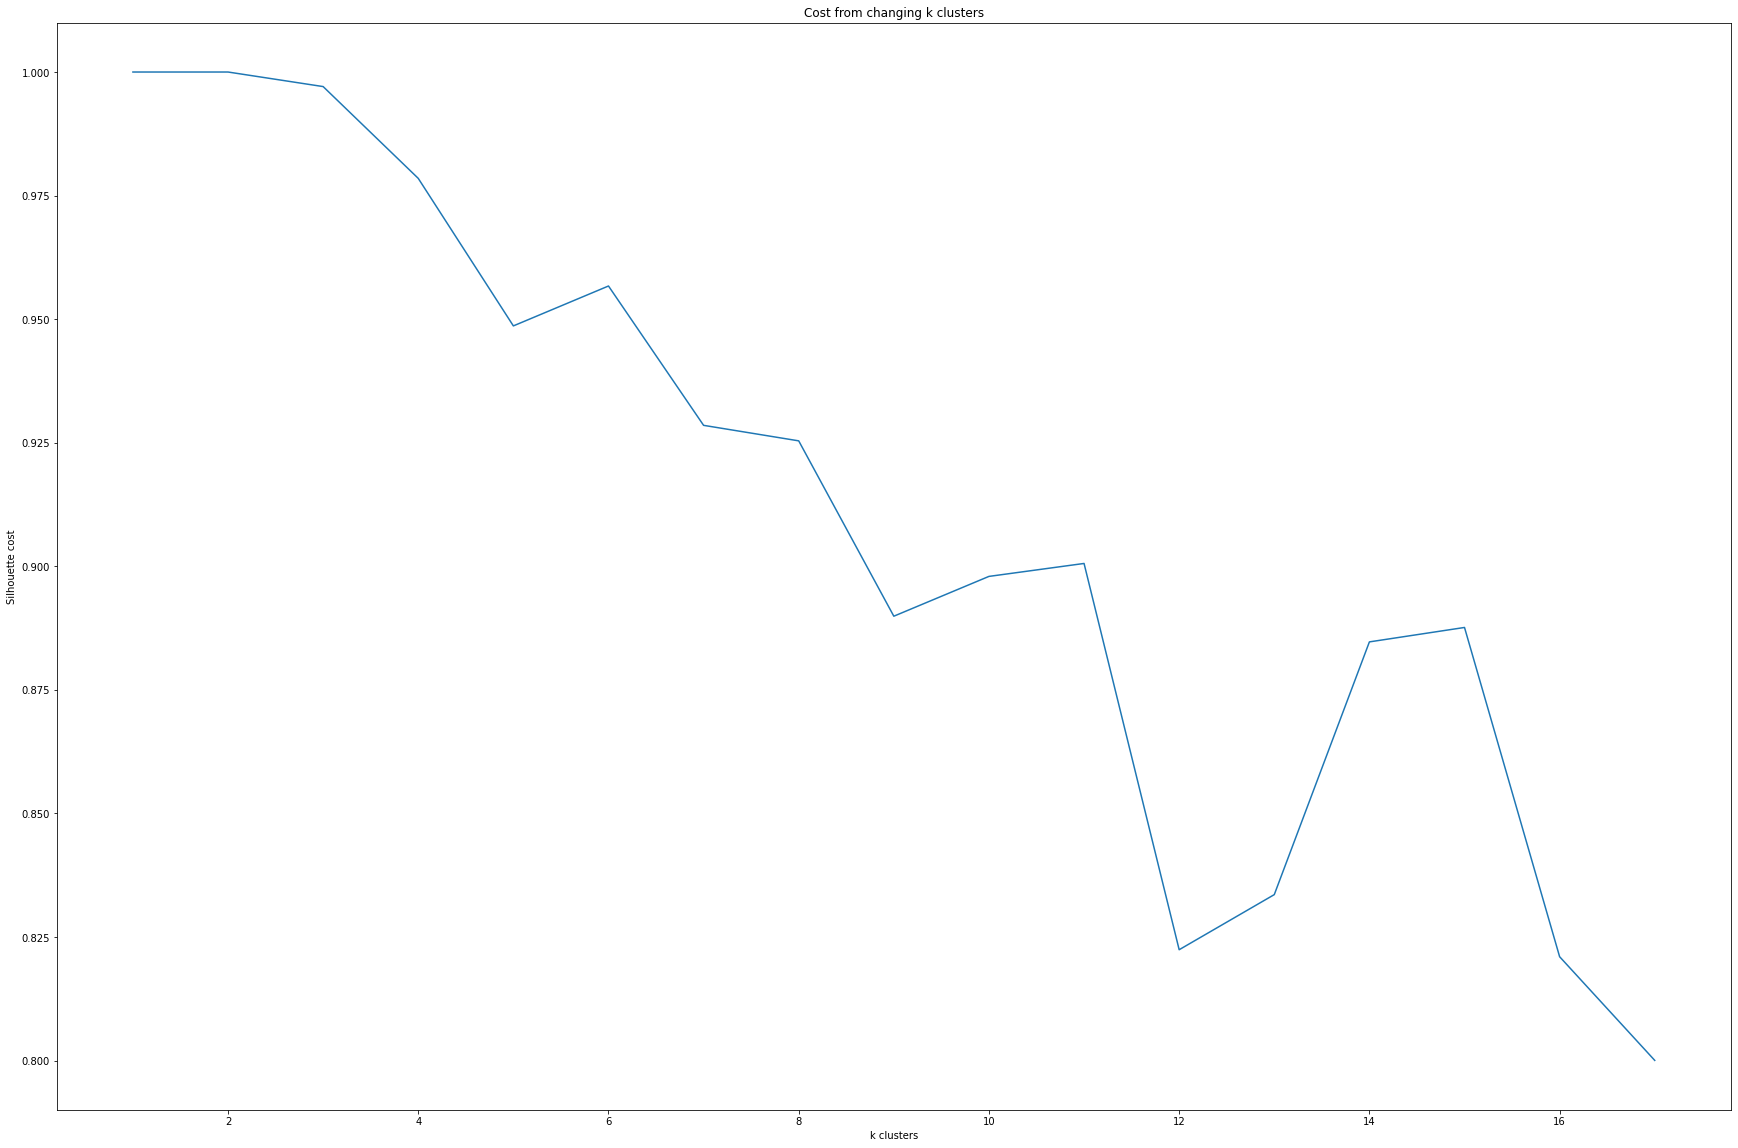

In [57]:
plt.plot(np.arange(1,18), cost, linestyle='solid')
plt.ylabel('Silhouette cost')
plt.xlabel('k clusters')
plt.title('Cost from changing k clusters')

In [58]:
# Trains a k-means model.
kmeans = KMeans(k=10).setSeed(1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

cost[k] = silhouette

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
    
cluster_predictions = predictions.toPandas()

Silhouette with squared euclidean distance = 0.9005781755056251
Cluster Centers: 
[1.68181818e+00 7.23207071e+01 2.13566498e+03 4.13455387e+02
 2.53200589e+03 1.92657155e+03 0.00000000e+00 5.21885522e-01
 3.93939394e-01 4.30530303e+02 2.03747475e+02 2.49579125e+00
 1.85284512e+02 2.48653199e+00 6.52104377e+00 2.77777778e-02
 8.41750842e-04 2.08754209e-01 1.95707071e+00 4.20875421e-02
 6.68661616e+01 2.96877104e+01 2.15749158e+01 4.57255052e+01
 5.11717172e+01 6.86399155e+01 2.77272727e+00 4.86616162e+00
 1.16006448e+02 1.40770590e+02 1.41865201e+02 1.22169257e+02
 9.49103274e+01 8.48763488e+01 7.62705294e+01 9.77796309e+00
 4.06048527e+00 4.25589824e+00 4.36792577e+00 1.05493321e+01
 4.72767615e+00 2.13644152e+00 9.88277858e-01 1.28744198e+00
 8.38691058e-01 8.44167459e-01 1.23313906e+00 9.27786189e-01
 9.96730806e-01]
[0.00000000e+00 8.60000000e+01 7.80670000e+05 6.80224000e+05
 1.45957800e+06 2.99900000e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.87000000e+02 3.87000000e+02 0

In [59]:
cluster_predictions

,type,name,required_age,appid,release_date,initial_price,metacritic_score,windows,mac,linux,...,isMajorTitle_num,tier_num,game_type_num,windows_num,mac_num,linux_num,developer_num,publisher_num,features,prediction
0,game,OVERKILL's The Walking Dead,17,717690,2018-11-06,2999.0,51.0,True,False,False,...,0,0,0,0,0,0,0,0,"(17.0, 51.0, 2756.0, 2608.0, 5299.0, 2999.0, 0...",0
1,game,Hyper Light Drifter,0,257850,2016-03-31,1999.0,84.0,True,True,True,...,1,1,0,0,1,1,1,1,"(0.0, 84.0, 10848.0, 656.0, 11496.0, 1999.0, 0...",0
2,game,Marooners,0,423810,2016-09-15,999.0,70.0,True,True,True,...,0,0,0,0,1,1,2,2,"(0.0, 70.0, 175.0, 105.0, 270.0, 999.0, 0.0, 1...",0
3,game,The Witcher 3: Wild Hunt,0,292030,2015-05-18,3999.0,93.0,True,False,False,...,0,1,0,0,0,0,3,3,"(0.0, 93.0, 466466.0, 9620.0, 475908.0, 3999.0...",3
4,game,Stick It To The Man!,0,251830,2013-12-13,799.0,83.0,True,True,False,...,0,2,0,0,1,0,4,4,"(0.0, 83.0, 388.0, 20.0, 397.0, 799.0, 0.0, 1....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,game,"Invisible, Inc.",0,243970,2015-05-12,1999.0,82.0,True,True,True,...,1,2,0,0,1,1,303,209,"(0.0, 82.0, 3924.0, 351.0, 4249.0, 1999.0, 0.0...",0
1350,game,Take On Mars,0,244030,2017-02-09,2699.0,62.0,True,False,False,...,0,4,0,0,0,0,967,620,"(0.0, 62.0, 940.0, 752.0, 1633.0, 2699.0, 0.0,...",0
1351,game,Party Hard 2,0,572430,2018-10-25,1999.0,74.0,True,True,False,...,0,3,0,0,1,0,814,41,"(0.0, 74.0, 1023.0, 233.0, 1230.0, 1999.0, 0.0...",0
1352,game,My Friend Pedro,0,557340,2019-06-20,1999.0,81.0,True,False,False,...,1,2,0,0,0,0,968,6,"(0.0, 81.0, 18550.0, 710.0, 19179.0, 1999.0, 0...",6


In [60]:
cluster_predictions['prediction'].unique()

array([0, 3, 6, 2, 8, 7, 4, 1, 9, 5], dtype=int32)

In [61]:
df['cluster_prediction'] = cluster_predictions['prediction'].values

In [62]:
df['cluster_prediction'].unique()

array([0, 3, 6, 2, 8, 7, 4, 1, 9, 5], dtype=int32)

In [63]:
feature_list = feature_list + ['cluster_prediction']
print(feature_list)

['required_age', 'metacritic_score', 'sum_recommendations_up', 'sum_recommendations_down', 'total_recommendations', 'initial_price', 'windows_num', 'mac_num', 'linux_num', 'developer_num', 'publisher_num', 'number_dlc', 'release_day_in_year', 'number_genres', 'number_categories', 'type_num', 'hasLootBoxes_num', 'isMajorTitle_num', 'tier_num', 'game_type_num', 'medianScore', 'numReviews', 'numTopCriticReviews', 'percentRecommended', 'percentile', 'topCriticScore', 'number_platforms', 'number_skus', 'start_players_-1', 'start_players_0', 'start_players_1', 'start_players_2', 'start_players_3', 'start_players_4', 'start_players_5', 'start_twitch_viewers_-1', 'start_twitch_viewers_0', 'start_twitch_viewers_1', 'start_twitch_viewers_2', 'start_twitch_viewers_3', 'start_twitch_viewers_4', 'start_twitch_viewers_5', 'start_twitch_rank_-1', 'start_twitch_rank_0', 'start_twitch_rank_1', 'start_twitch_rank_2', 'start_twitch_rank_3', 'start_twitch_rank_4', 'start_twitch_rank_5', 'cluster_predictio

In [64]:
# persist and serialize objects to disk for next step
pickle.dump(df, open("/work/df.p", "wb"))
pickle.dump(feature_list, open("/work/feature_list.p", "wb"))

In [65]:
sc.stop()